<a href="https://colab.research.google.com/github/sdittmeier/pytorch_course/blob/main/pytorch_trackml_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install trackml dependency from repository
!pip install git+https://github.com/LAL/trackml-library

  Cloning https://github.com/LAL/trackml-library to /tmp/pip-req-build-m28u8mkw
  Running command git clone --filter=blob:none --quiet https://github.com/LAL/trackml-library /tmp/pip-req-build-m28u8mkw
  Resolved https://github.com/LAL/trackml-library to commit 53a165e15a2c885f54c2bef1bd1ed53db6ed9648
  Preparing metadata (setup.py) ... done


In [2]:
# download of zipped datasets
!mkdir datasets
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/testset.zip
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/valset.zip
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/trainset.zip

mkdir: cannot create directory ‘datasets’: File exists
--2024-03-21 21:52:46--  https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/testset.zip
Resolving www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)... 147.142.19.243
Connecting to www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)|147.142.19.243|:443... connected.
^C
--2024-03-21 21:52:48--  https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/trackml_data/valset.zip
Resolving www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)... 147.142.19.243
Connecting to www.physi.uni-heidelberg.de (www.physi.uni-heidelberg.de)|147.142.19.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81081570 (77M) [application/zip]
Saving to: ‘valset.zip.1’

valset.zip.1        100%[===================>]  77.33M  18.7MB/s    in 5.1s    

2024-03-21 21:52:54 (15.2 MB/s) - ‘valset.zip.1’ saved [81081570/81081570]

--2024-03-21 21:52:54--  https://www.physi.uni-heidelberg.de/~dittmeier/pytor

In [3]:
# and unzip them into our datasets directory
!unzip trainset.zip -d datasets
!unzip valset.zip -d datasets
!unzip testset.zip -d datasets

Archive:  trainset.zip
replace datasets/trainset/event000021077-particles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  valset.zip
replace datasets/valset/event000021094-particles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  testset.zip
replace datasets/testset/event000021082-particles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Imports
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import trackml.dataset
from trackml.utils import add_momentum_quantities
import matplotlib.pyplot as plt
import numpy as np


In [5]:
# helper for GPU training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

cuda


   hit_id         particle_id         tx        ty      tz       tpx  \
0       1  238697583478833152 -86.806602 -14.74600 -1502.5 -0.247412   
1       2  671044522095935488 -68.705399 -10.91280 -1502.5 -0.526919   
2       3  774632811083595776 -56.143101  -9.52382 -1502.5 -1.053290   
3       4  945760182355361792 -60.311501  -4.98039 -1502.5 -1.179080   
4       5  837680800685096960 -89.389702  -8.82342 -1502.5 -1.395490   

        tpy        tpz    weight  
0 -0.068921  -4.570100  0.000006  
1 -0.108128 -11.914000  0.000007  
2 -0.156064 -28.250999  0.000017  
3 -0.120229 -30.253500  0.000016  
4 -0.106162 -23.752899  0.000018  
0                     17851
968276737383202816       20
932250276826447872       19
454865967546105856       18
45038951211204608        18
                      ...  
67556124731117569         1
481891551056764930        1
247711104942219266        1
666536386983100416        1
945772208280571905        1
Name: particle_id, Length: 10892, dtype: int64


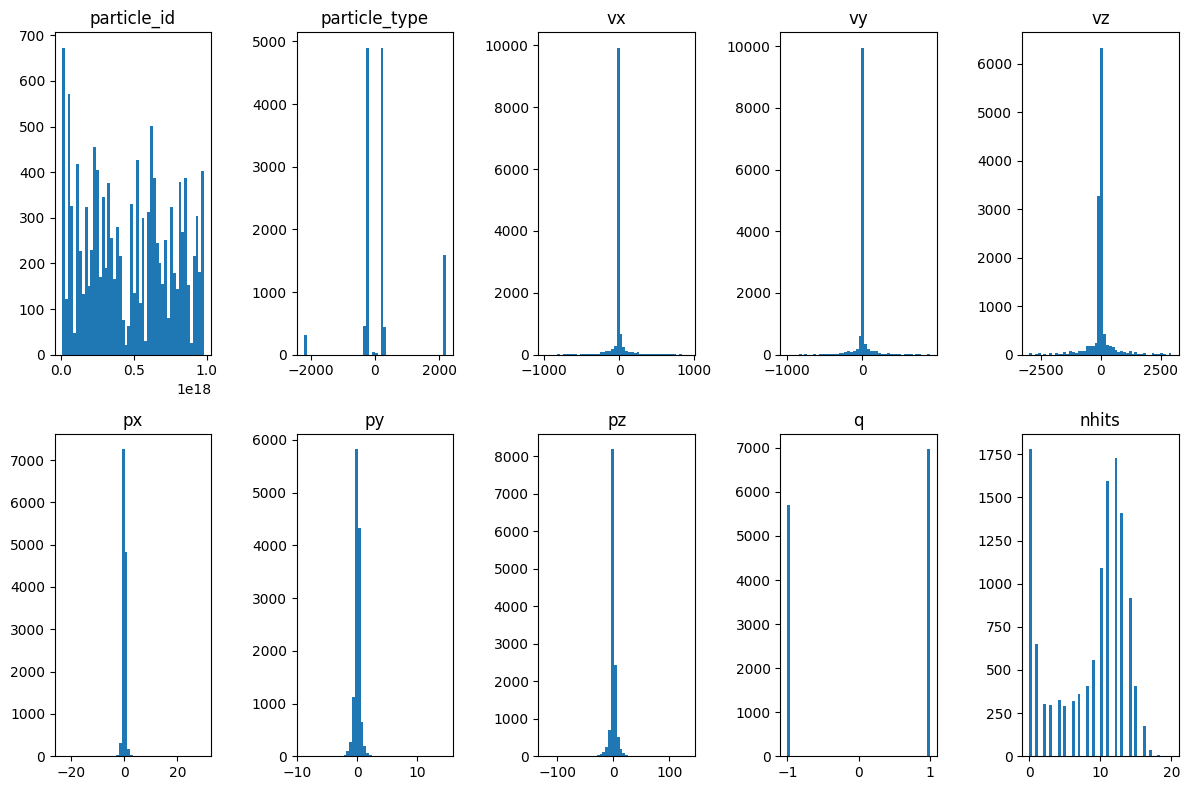

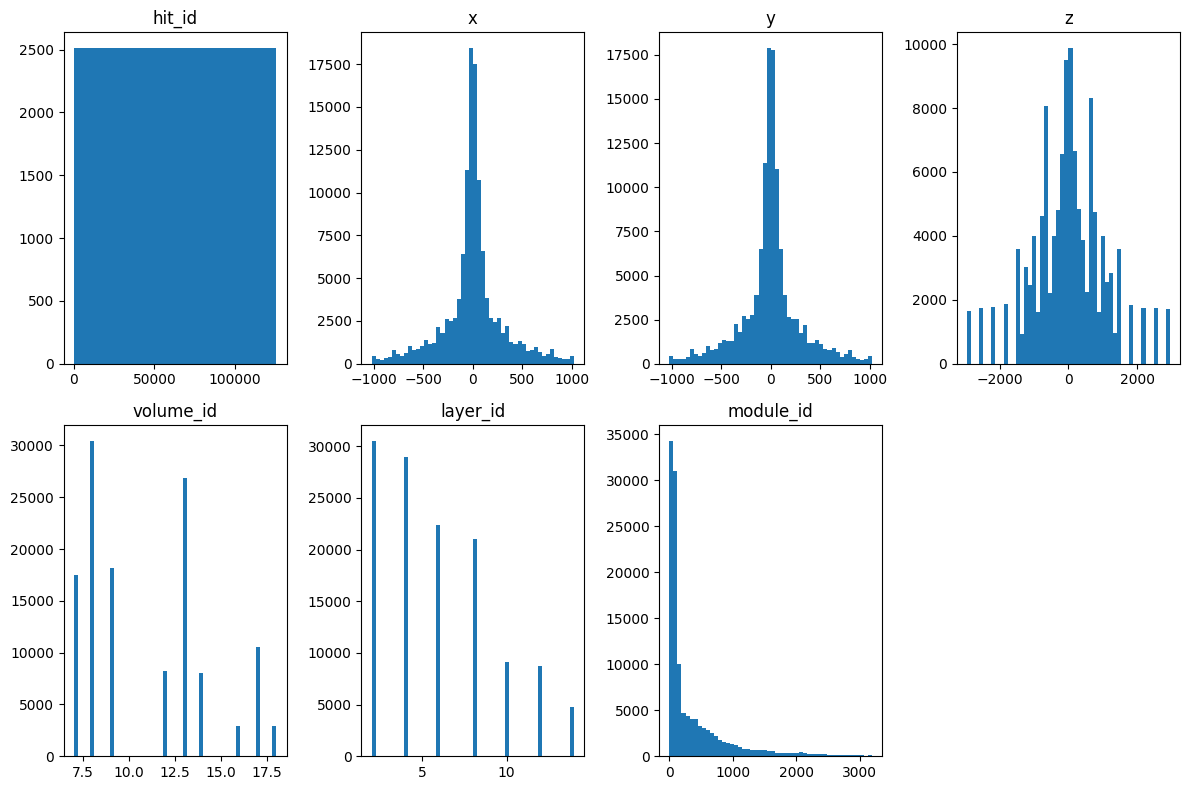

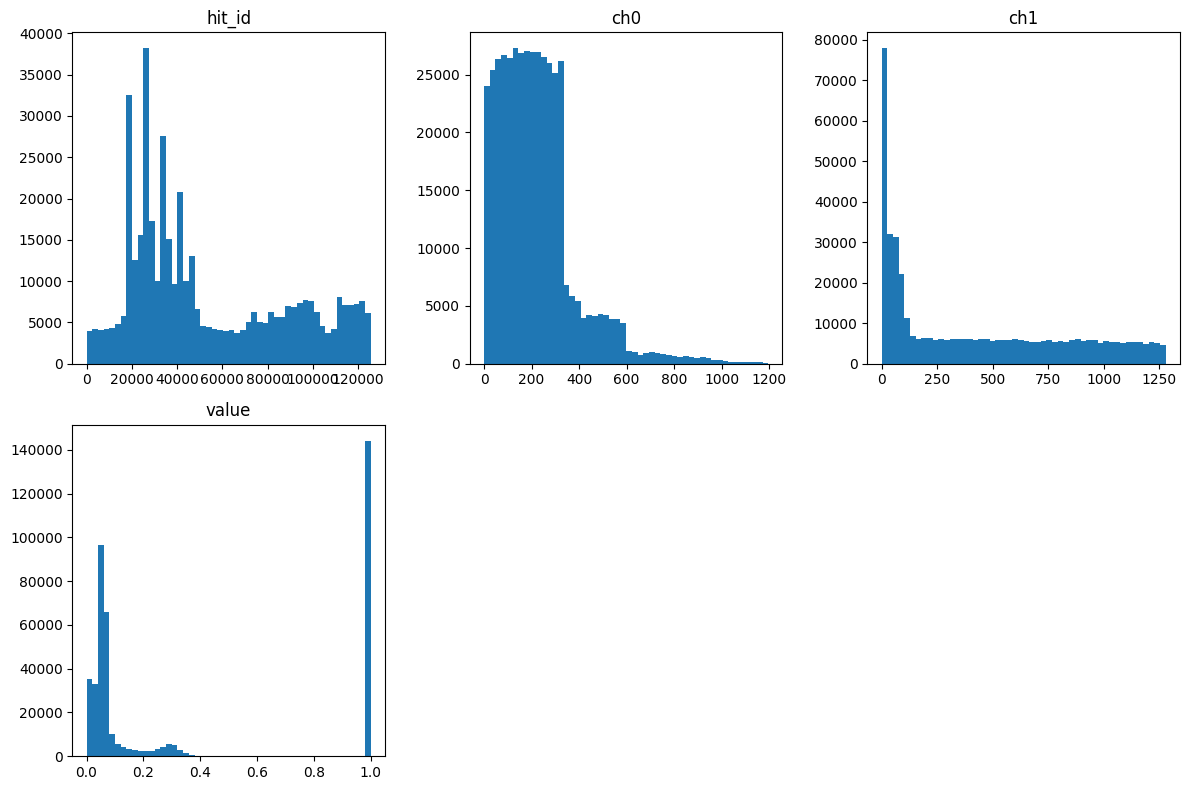

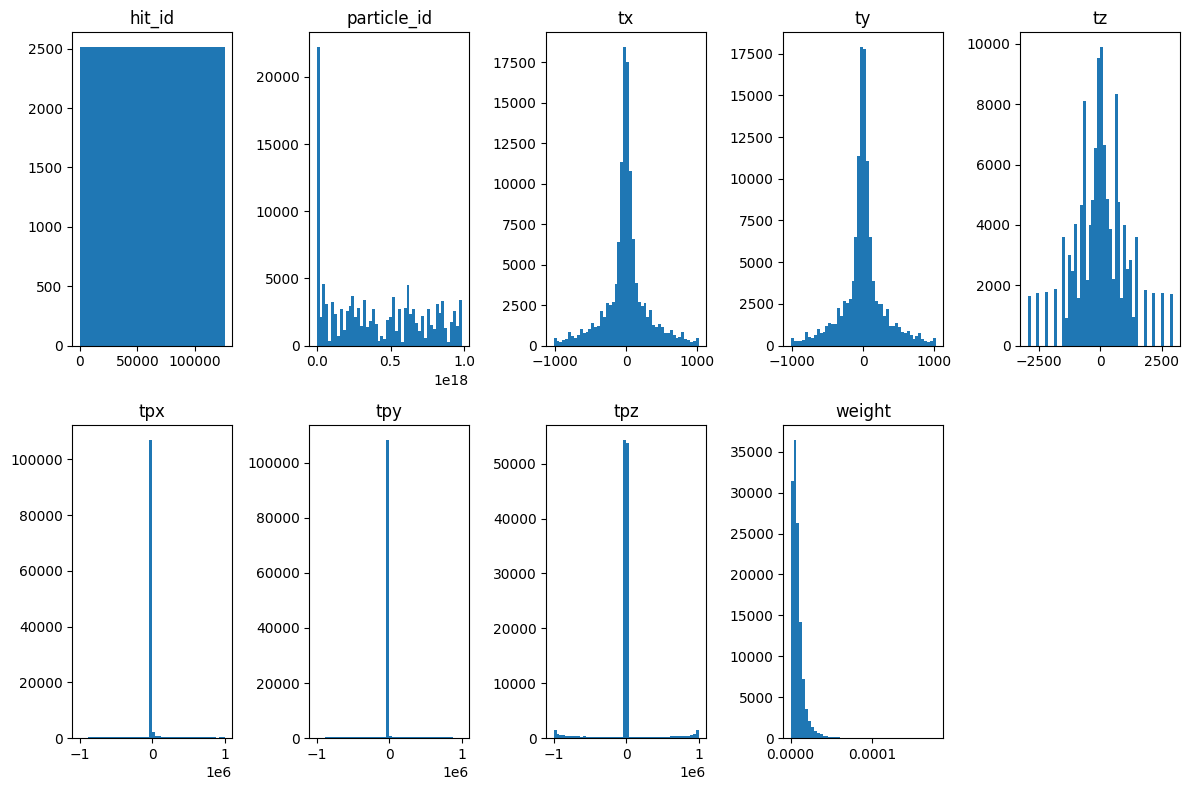

In [6]:
# Data Visualization
event_path = "datasets/trainset/event000021000"

particles, hits, cells, truth = trackml.dataset.load_event(
    event_path, parts=["particles", "hits", "cells", "truth"]
)

print(truth.head())
print(truth["particle_id"].value_counts())

# Create histograms for particles
plt.figure(figsize=(12, 8))
for i, column in enumerate(particles.columns):
    plt.subplot(2, 5, i+1)
    plt.hist(particles[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for hits
plt.figure(figsize=(12, 8))
for i, column in enumerate(hits.columns):
    plt.subplot(2, 4, i+1)
    plt.hist(hits[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for cells
plt.figure(figsize=(12, 8))
for i, column in enumerate(cells.columns):
    plt.subplot(2, 3, i+1)
    plt.hist(cells[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()

# Create histograms for truth
plt.figure(figsize=(12, 8))
for i, column in enumerate(truth.columns):
    plt.subplot(2, 5, i+1)
    plt.hist(truth[column], bins=50)
    plt.title(column)
plt.tight_layout()
plt.show()


In [7]:
# more visualisation, setup for a 3D plot
!pip install ipympl
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

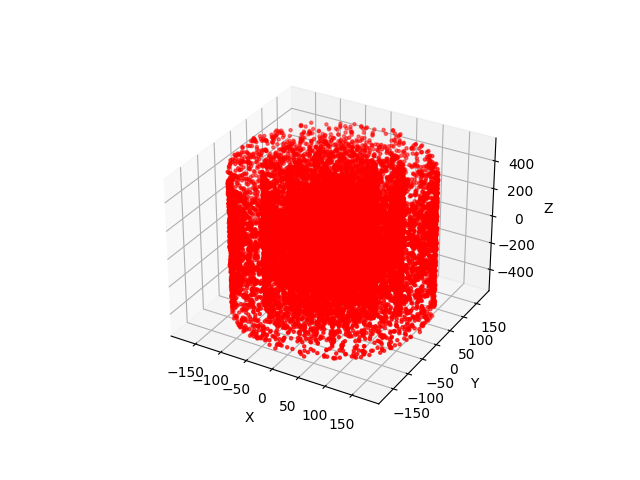

In [8]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hits_select = hits[hits.volume_id==8]
ax.scatter(hits_select.x, hits_select.y, hits_select.z, c='r', marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [9]:
# Create a dataset, with a label for each hit, if hits have same particle_id set to 1, else -1
# and an option to apply a cut on pT on the dataset

class TrackMLDataset(Dataset):
    def __init__(self, event_path, nevents=10, cuts=None):
        self.event_path = event_path
        self.nevents = nevents
        self.event_ids = []
        self.particles = []
        self.hits = []
        self.cells = []
        self.truth = []
        self.labels = []

        for event_id, hits, cells, particles, truth in trackml.dataset.load_dataset(event_path, nevents=nevents):
            particles = add_momentum_quantities(particles)
            print(event_id)
            if cuts is not None:
                print(f"Applying cuts: {cuts}")
                particles = particles[particles.pt >= cuts["pt"]].reset_index(drop=True)
                truth = truth[truth.particle_id.isin(particles.particle_id)].reset_index(drop=True)
                hits  = hits[hits.hit_id.isin(truth.hit_id)].reset_index(drop=True)
                cells = cells[cells.hit_id.isin(hits.hit_id)].reset_index(drop=True)

            self.event_ids.append(event_id)
            self.particles.append(particles)
            self.hits.append(hits)
            self.cells.append(cells)
            self.truth.append(truth)

            labels = np.full((len(truth), len(truth)), -1, dtype=np.int8)    # this is not memory friendly!!!
            for particle_id, nhits in zip(particles.particle_id, particles.nhits):
                particle_hits = truth[truth.particle_id == particle_id].index
                for match in particle_hits:
                    for match2 in particle_hits:
                        labels[match, match2] = 1

            # think about metric learning approach; make use of volumes and layers

            self.labels.append(labels)

    def __len__(self):
        return len(self.event_ids)

    def __getitem__(self, idx):
        event_id = self.event_ids[idx]
        particles = self.particles[idx]
        hits = self.hits[idx]
        cells = self.cells[idx]
        truth = self.truth[idx]
        labels = self.labels[idx]
        return event_id, torch.tensor(particles.values, dtype=torch.float32), torch.tensor(hits.values, dtype=torch.float32), torch.tensor(cells.values, dtype=torch.float32), torch.tensor(truth.values, dtype=torch.float32), torch.from_numpy(labels).type(torch.int8)


In [10]:
# Loading the dataset
print("Loading Trainset")
event_path = "datasets/trainset"
training_data = TrackMLDataset(event_path, nevents=80, cuts={"pt": 2})
print("Loading Valset")
event_path = "datasets/valset"
val_data = TrackMLDataset(event_path, nevents=10, cuts={"pt": 2})
print("Loading Testset")
event_path = "datasets/testset"
test_data = TrackMLDataset(event_path, nevents=10, cuts={"pt": 2})

Loading Trainset
21000
Applying cuts: {'pt': 2}
21001
Applying cuts: {'pt': 2}
21002
Applying cuts: {'pt': 2}
21003
Applying cuts: {'pt': 2}
21004
Applying cuts: {'pt': 2}
21005
Applying cuts: {'pt': 2}
21006
Applying cuts: {'pt': 2}
21007
Applying cuts: {'pt': 2}
21008
Applying cuts: {'pt': 2}
21009
Applying cuts: {'pt': 2}
21010
Applying cuts: {'pt': 2}
21011
Applying cuts: {'pt': 2}
21012
Applying cuts: {'pt': 2}
21013
Applying cuts: {'pt': 2}
21014
Applying cuts: {'pt': 2}
21015
Applying cuts: {'pt': 2}
21016
Applying cuts: {'pt': 2}
21017
Applying cuts: {'pt': 2}
21018
Applying cuts: {'pt': 2}
21019
Applying cuts: {'pt': 2}
21020
Applying cuts: {'pt': 2}
21021
Applying cuts: {'pt': 2}
21022
Applying cuts: {'pt': 2}
21023
Applying cuts: {'pt': 2}
21024
Applying cuts: {'pt': 2}
21025
Applying cuts: {'pt': 2}
21026
Applying cuts: {'pt': 2}
21027
Applying cuts: {'pt': 2}
21028
Applying cuts: {'pt': 2}
21029
Applying cuts: {'pt': 2}
21030
Applying cuts: {'pt': 2}
21031
Applying cuts: {

In [11]:
# Setting up DataLoader
batch_size = 1
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Getting a first test event
event_id, particles, hits, cells, truth, labels = next(iter(train_dataloader))

print(f"event_id shape: {event_id.size()}; event_id data type: {event_id.dtype}")
print(f"particles shape: {particles.size()}; particles data type: {particles.dtype}")
print(f"hits shape: {hits.size()}; hits data type: {hits.dtype}")
print(f"cells shape: {cells.size()}; cells data type: {cells.dtype}")
print(f"truth shape: {truth.size()}; truth data type: {truth.dtype}")
print(f"labels shape: {labels.size()}; labels data type: {labels.dtype}")

print(f"event_id: {event_id.squeeze()}")
print(f"hit coordinates: {hits.squeeze()[:,1:4]}")    # x, y, z
print(f"labels: {labels.squeeze()}")



event_id shape: torch.Size([1]); event_id data type: torch.int64
particles shape: torch.Size([1, 220, 14]); particles data type: torch.float32
hits shape: torch.Size([1, 2325, 7]); hits data type: torch.float32
cells shape: torch.Size([1, 7303, 4]); cells data type: torch.float32
truth shape: torch.Size([1, 2325, 9]); truth data type: torch.float32
labels shape: torch.Size([1, 2325, 2325]); labels data type: torch.int8
event_id: 21055
hit coordinates: tensor([[   13.8296,  -114.5220, -1502.0000],
        [    9.9588,   -57.0097, -1497.5000],
        [   37.7088,   -99.2127, -1502.0000],
        ...,
        [  744.8330,   506.7240,  2952.5000],
        [  482.1950,   609.2610,  2947.5000],
        [ -679.9250,   710.8120,  2952.5000]])
labels: tensor([[ 1, -1, -1,  ..., -1, -1, -1],
        [-1,  1, -1,  ..., -1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ...,  1, -1, -1],
        [-1, -1, -1,  ..., -1,  1, -1],
        [-1, -1, -1,  ..., -1, -1

In [12]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential( # Sequential container
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 8),
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

# instantiates the model and sends it to GPU
model = NeuralNetwork().to(device)

In [13]:
learning_rate = 1e-3
batch_size = batch_size
epochs = 50
margin = 1.0

loss_fn = nn.HingeEmbeddingLoss(margin=margin)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# loops over our optimization code
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, [event_id, particles, hits, cells, truth, labels] in enumerate(dataloader):
        # Send data to GPU
        particles, hits, cells, truth, labels = to_device([particles, hits, cells, truth, labels], device)

        embedding = model(hits.squeeze()[:,1:4])
        distances = torch.cdist(embedding, embedding)

        loss = loss_fn(distances, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(event_id)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # Clear GPU memory
        del event_id, particles, hits, cells, truth, embedding, distances, labels, loss
        torch.cuda.empty_cache()



In [43]:
# we want to do a knn from scikit
from sklearn.neighbors import NearestNeighbors

def evaluate(embeddings, labels, knn, radius):
  embeddings_cpu = embeddings.cpu().detach().numpy()

  neigh = NearestNeighbors(n_neighbors=knn, radius=radius)
  neigh.fit(embeddings_cpu)
  distances, indices = neigh.kneighbors(embeddings_cpu)
  #print(distances)
  #print(indices)

  positives = 0
  negatives = 0

  count_1 = torch.sum(labels == 1).item()

  for ind in indices:
    # we can just check with labels, if knn and label = 1 --> match, -1 --> bad
    #print(ind)
      positives += torch.sum(labels.squeeze()[ind[0],ind[1:]] == 1).item()
      negatives += torch.sum(labels.squeeze()[ind[0],ind[1:]] == -1).item()
  print(f"positives: {positives}; negatives: {negatives}; count_1: {count_1}")
  efficiency = positives/count_1
  purity = positives/(positives + negatives)
  return efficiency, purity

In [28]:
# evaluate the model's performance against the test dataset
def test_loop(dataloader, model, loss_fn, device, knn, radius):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, efficiency, purity = 0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for event_id, particles, hits, cells, truth, labels  in dataloader:
            # Send data to GPU
            particles, hits, cells, truth, labels = to_device([particles, hits, cells, truth, labels], device)

            embedding = model(hits.squeeze()[:,1:4])
            distances = torch.cdist(embedding, embedding)

            test_loss += loss_fn(distances, labels).item()

            eff, pur = evaluate(embedding, labels, knn, radius)
            efficiency += eff
            purity += pur

            del event_id, particles, hits, cells, truth, embedding, distances, labels

    test_loss /= num_batches
    efficiency /= num_batches
    purity /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} Efficiency: {efficiency:>8f} Purity: {purity:>8f} \n")
    return test_loss, efficiency, purity

In [17]:
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    val_loss.append(test_loop(val_dataloader, model, loss_fn, device, 21, 1.0))
print("Done!")


Epoch 1
-------------------------------
loss: 0.093586  [    1/   80]
loss: 0.020309  [   11/   80]
loss: 0.017636  [   21/   80]
loss: 0.022930  [   31/   80]
loss: 0.018871  [   41/   80]
loss: 0.019923  [   51/   80]
loss: 0.018609  [   61/   80]
loss: 0.020611  [   71/   80]
Test Error: 
 Avg loss: 0.016787 Efficiency: 0.176613 Purity: 0.041473 

Epoch 2
-------------------------------
loss: 0.016599  [    1/   80]
loss: 0.015286  [   11/   80]
loss: 0.017209  [   21/   80]
loss: 0.013883  [   31/   80]
loss: 0.016751  [   41/   80]
loss: 0.010778  [   51/   80]
loss: 0.010862  [   61/   80]
loss: 0.011807  [   71/   80]
Test Error: 
 Avg loss: 0.012513 Efficiency: 0.202641 Purity: 0.093648 

Epoch 3
-------------------------------
loss: 0.012136  [    1/   80]
loss: 0.009923  [   11/   80]
loss: 0.010961  [   21/   80]
loss: 0.010213  [   31/   80]
loss: 0.009699  [   41/   80]
loss: 0.010203  [   51/   80]
loss: 0.009882  [   61/   80]
loss: 0.008512  [   71/   80]
Test Error: 
 

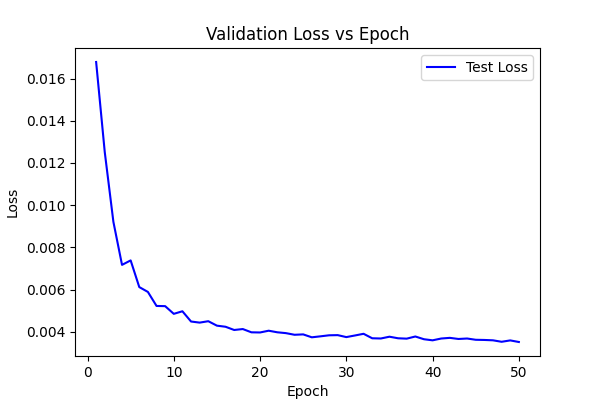

In [22]:
#for name, param in model.named_parameters():
#    print(f"Parameter name: {name}, Size: {param.size()}, Values: {param}")

# Assuming you have the `test_loss` variable containing the loss values for each epoch
epochs = range(1, len(val_loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, val_loss, 'b', label='Test Loss')
plt.title('Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [47]:
test_loop(val_dataloader, model, loss_fn, device, 50, 10.0)
test_loop(val_dataloader, model, loss_fn, device, 100, 100.0)

positives: 26327; negatives: 98770; count_1: 30723
positives: 29586; negatives: 114866; count_1: 35054
positives: 18437; negatives: 66333; count_1: 20340
positives: 26539; negatives: 103801; count_1: 31254
positives: 21632; negatives: 77152; count_1: 24708
positives: 33137; negatives: 129004; count_1: 39123
positives: 37680; negatives: 146707; count_1: 44699
positives: 36742; negatives: 136914; count_1: 42972
positives: 27557; negatives: 101607; count_1: 31708
positives: 26325; negatives: 99556; count_1: 30367
Test Error: 
 Avg loss: 0.003514 Efficiency: 0.861298 Purity: 0.209814 

positives: 35139; negatives: 292452; count_1: 39123
positives: 27920; negatives: 235420; count_1: 31254
positives: 27472; negatives: 226859; count_1: 30367
positives: 18597; negatives: 152673; count_1: 20340
positives: 22424; negatives: 177160; count_1: 24708
positives: 28621; negatives: 232343; count_1: 31708
positives: 27727; negatives: 225020; count_1: 30723
positives: 31208; negatives: 260644; count_1: 3

(0.0035135839600116013, 0.8994909287419848, 0.1084528873226159)